YEAR:  2007
        id   latitude  longitude    cp                  ville  \
0  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
1  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
2  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
3  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
4  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   

           adresse     nom               maj  valeur  
0  ROUTE NATIONALE  Gazole  2007_01_04_18:43   999.0  
1  ROUTE NATIONALE  Gazole  2007_01_09_08:32   999.0  
2  ROUTE NATIONALE  Gazole  2007_01_12_08:42   989.0  
3  ROUTE NATIONALE  Gazole  2007_01_16_16:18   988.0  
4  ROUTE NATIONALE  Gazole  2007_01_17_09:16   988.0  
        id   latitude  longitude    cp                  ville  \
0  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
1  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
2  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
3  1000

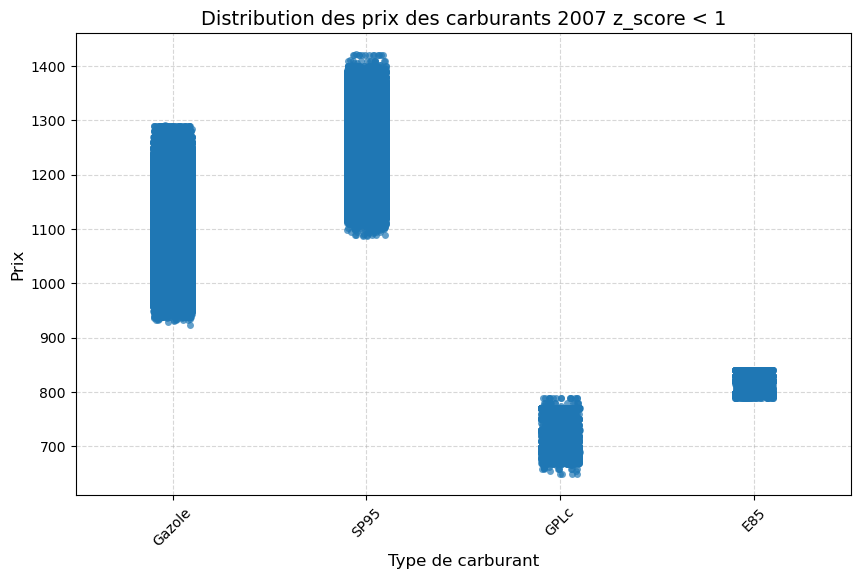

Save to CSV PrixCarburants_annuel_filtered_2007.csv
YEAR:  2008
        id   latitude  longitude    cp                  ville  \
0  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
1  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
2  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
3  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
4  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   

           adresse     nom               maj  valeur  
0  ROUTE NATIONALE  Gazole  2008_01_04_08:50  1189.0  
1  ROUTE NATIONALE  Gazole  2008_01_07_10:18  1199.0  
2  ROUTE NATIONALE  Gazole  2008_01_15_08:39  1179.0  
3  ROUTE NATIONALE  Gazole  2008_01_18_08:11  1169.0  
4  ROUTE NATIONALE  Gazole  2008_01_19_12:02  1164.0  
        id   latitude  longitude    cp                  ville  \
0  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
1  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
2  1000001  4620114.

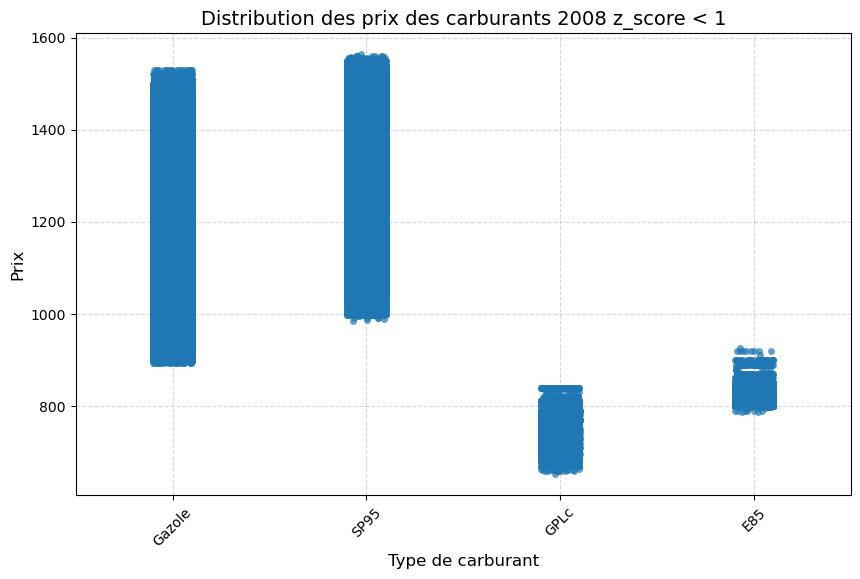

Save to CSV PrixCarburants_annuel_filtered_2008.csv
YEAR:  2009
        id   latitude  longitude    cp                  ville  \
0  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
1  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
2  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
3  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
4  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   

           adresse     nom               maj  valeur  
0  ROUTE NATIONALE  Gazole  2009_01_05_08:53   909.0  
1  ROUTE NATIONALE  Gazole  2009_01_08_09:40   935.0  
2  ROUTE NATIONALE  Gazole  2009_01_10_08:58   965.0  
3  ROUTE NATIONALE  Gazole  2009_01_16_09:37   965.0  
4  ROUTE NATIONALE  Gazole  2009_01_21_09:41   965.0  
        id   latitude  longitude    cp                  ville  \
0  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
1  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
2  1000001  4620114.

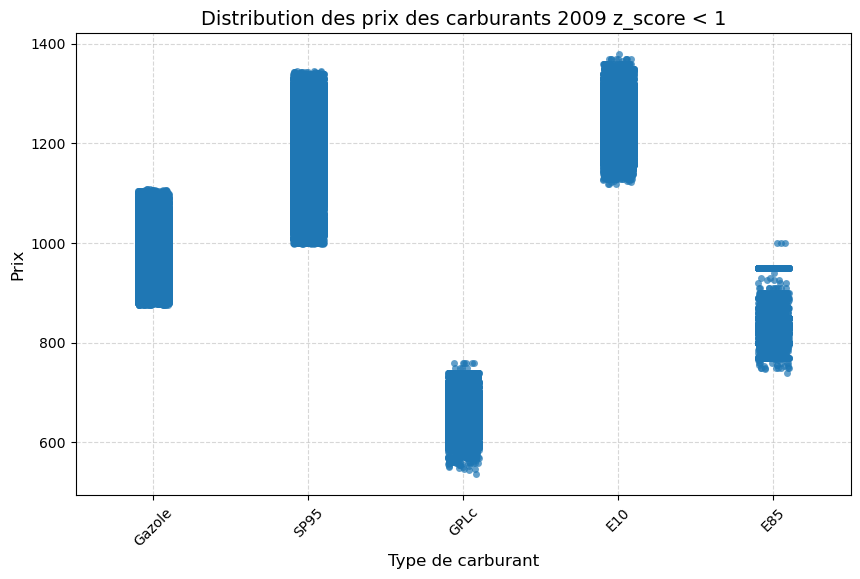

Save to CSV PrixCarburants_annuel_filtered_2009.csv
YEAR:  2010
        id   latitude  longitude    cp                  ville  \
0  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
1  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
2  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
3  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
4  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   

           adresse     nom               maj  valeur  
0  ROUTE NATIONALE  Gazole  2010_01_02_08:28  1018.0  
1  ROUTE NATIONALE  Gazole  2010_01_05_09:51  1028.0  
2  ROUTE NATIONALE  Gazole  2010_01_06_09:27  1028.0  
3  ROUTE NATIONALE  Gazole  2010_01_06_19:00  1039.0  
4  ROUTE NATIONALE  Gazole  2010_01_07_09:50  1039.0  
        id   latitude  longitude    cp                  ville  \
0  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
1  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
2  1000001  4620114.

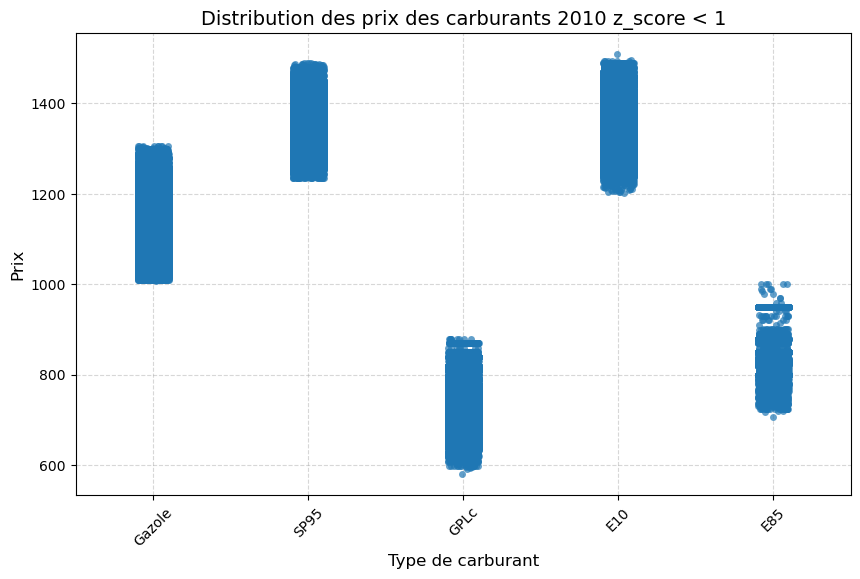

Save to CSV PrixCarburants_annuel_filtered_2010.csv
YEAR:  2011
        id   latitude  longitude    cp                  ville  \
0  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
1  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
2  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
3  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
4  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   

           adresse     nom               maj  valeur  
0  ROUTE NATIONALE  Gazole  2011_01_04_10:52  1202.0  
1  ROUTE NATIONALE  Gazole  2011_01_05_11:13  1202.0  
2  ROUTE NATIONALE  Gazole  2011_01_06_09:28  1205.0  
3  ROUTE NATIONALE  Gazole  2011_01_08_09:33  1208.0  
4  ROUTE NATIONALE  Gazole  2011_01_08_10:11  1211.0  
        id   latitude  longitude    cp                  ville  \
0  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
1  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
2  1000001  4620114.

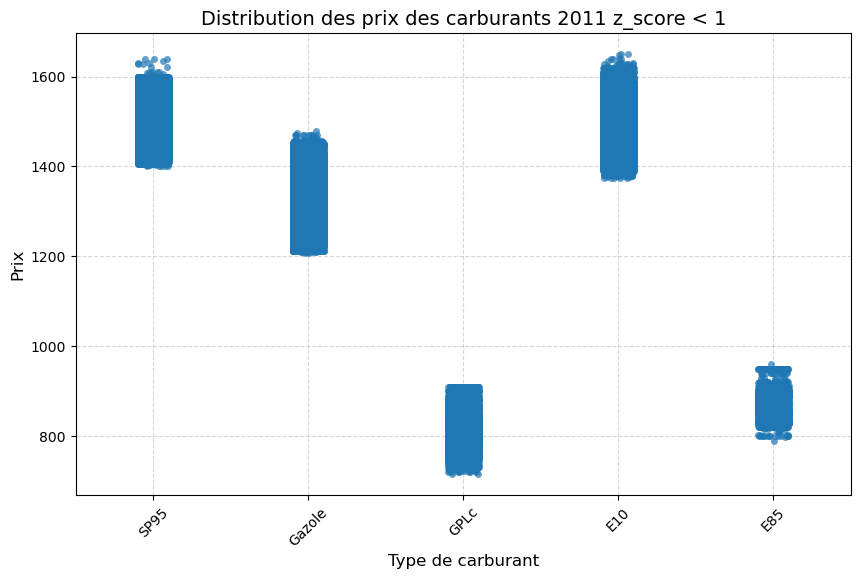

Save to CSV PrixCarburants_annuel_filtered_2011.csv
YEAR:  2012
        id   latitude  longitude    cp                  ville  \
0  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
1  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
2  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
3  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
4  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   

           adresse     nom               maj  valeur  
0  ROUTE NATIONALE  Gazole  2012_01_02_09:56  1332.0  
1  ROUTE NATIONALE  Gazole  2012_01_03_09:25  1336.0  
2  ROUTE NATIONALE  Gazole  2012_01_05_10:50  1346.0  
3  ROUTE NATIONALE  Gazole  2012_01_06_10:01  1355.0  
4  ROUTE NATIONALE  Gazole  2012_01_07_09:29  1364.0  
        id   latitude  longitude    cp                  ville  \
0  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
1  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
2  1000001  4620114.

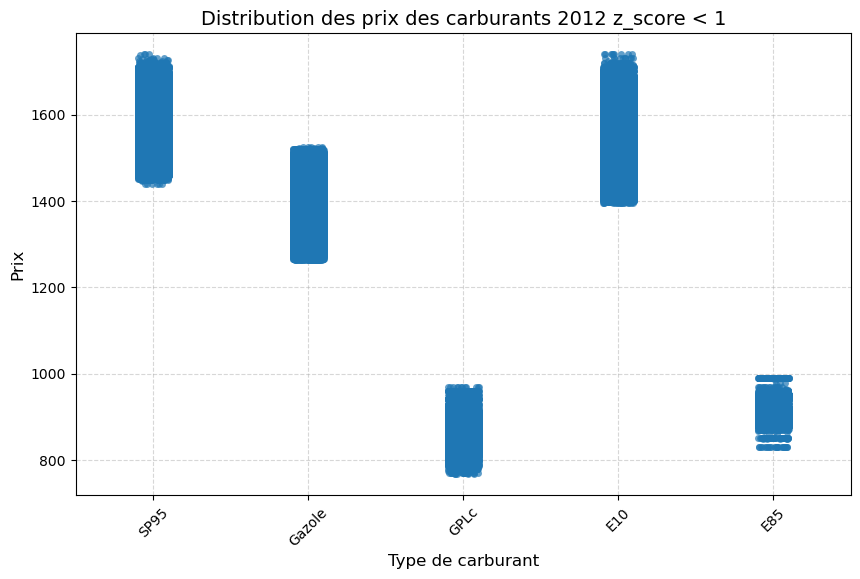

Save to CSV PrixCarburants_annuel_filtered_2012.csv
YEAR:  2013
        id   latitude  longitude    cp                  ville  \
0  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
1  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
2  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
3  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
4  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   

           adresse     nom               maj  valeur  
0  ROUTE NATIONALE  Gazole  2013_01_03_09:17  1299.0  
1  ROUTE NATIONALE  Gazole  2013_01_04_09:23  1309.0  
2  ROUTE NATIONALE  Gazole  2013_01_05_09:25  1309.0  
3  ROUTE NATIONALE  Gazole  2013_01_07_09:30  1315.0  
4  ROUTE NATIONALE  Gazole  2013_01_09_09:53  1315.0  
        id   latitude  longitude    cp                  ville  \
0  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
1  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
2  1000001  4620114.

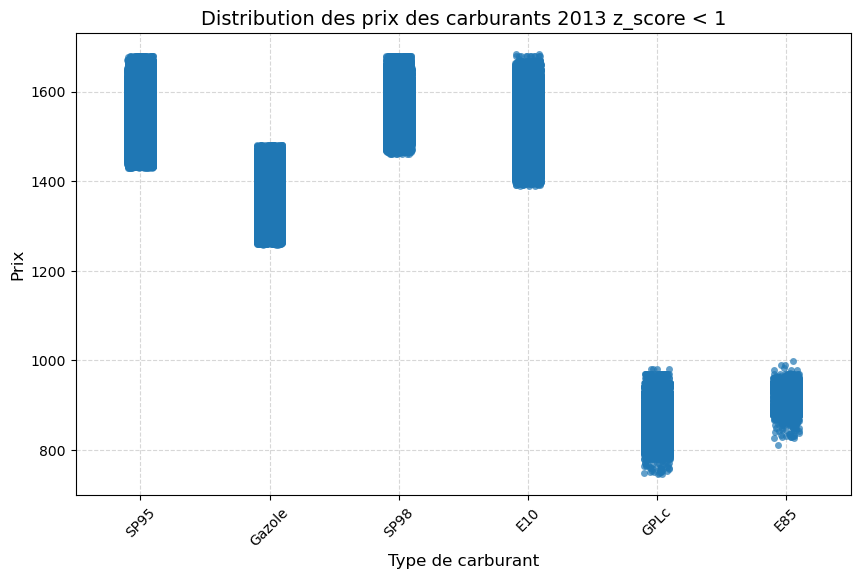

Save to CSV PrixCarburants_annuel_filtered_2013.csv
YEAR:  2014
        id   latitude  longitude    cp                  ville  \
0  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
1  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
2  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
3  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
4  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   

           adresse     nom               maj  valeur  
0  ROUTE NATIONALE  Gazole  2014_01_02_11:08  1304.0  
1  ROUTE NATIONALE  Gazole  2014_01_04_09:54  1304.0  
2  ROUTE NATIONALE  Gazole  2014_01_05_10:27  1304.0  
3  ROUTE NATIONALE  Gazole  2014_01_06_09:07  1304.0  
4  ROUTE NATIONALE  Gazole  2014_01_07_09:23  1304.0  
        id   latitude  longitude    cp                  ville  \
0  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
1  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
2  1000001  4620114.

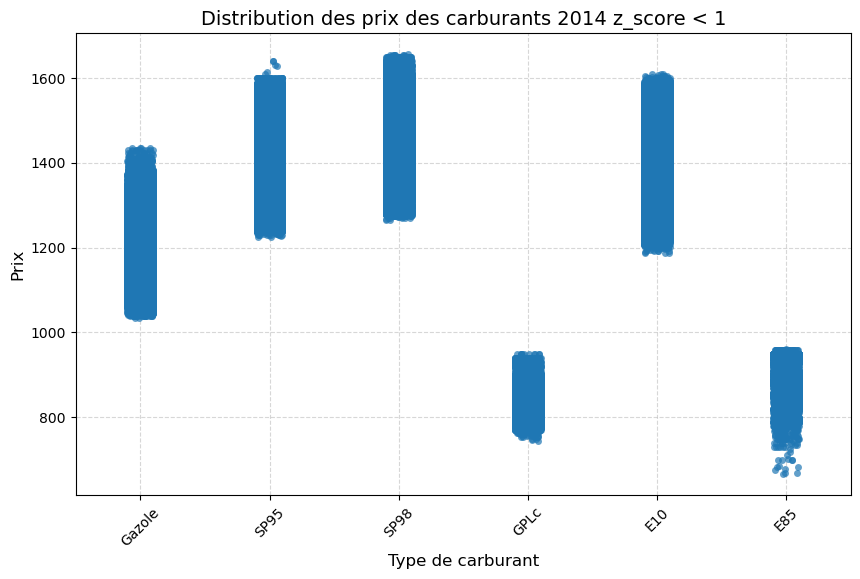

Save to CSV PrixCarburants_annuel_filtered_2014.csv
YEAR:  2015
        id   latitude  longitude    cp                  ville  \
0  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
1  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
2  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
3  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
4  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   

                 adresse     nom               maj  valeur  
0  596 AVENUE DE TREVOUX  Gazole  2015_01_02_11:01  1141.0  
1  596 AVENUE DE TREVOUX  Gazole  2015_01_03_09:01  1141.0  
2  596 AVENUE DE TREVOUX  Gazole  2015_01_07_10:01  1141.0  
3  596 AVENUE DE TREVOUX  Gazole  2015_01_08_10:01  1115.0  
4  596 AVENUE DE TREVOUX  Gazole  2015_01_09_10:01  1115.0  
        id   latitude  longitude    cp                  ville  \
0  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
1  1000001  4620114.0   519791.0  1000  SAINT-DEN

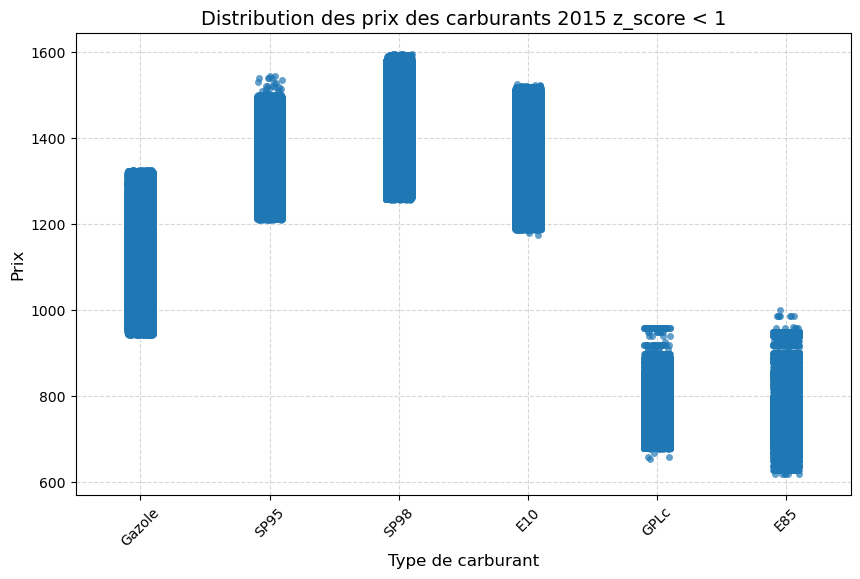

Save to CSV PrixCarburants_annuel_filtered_2015.csv
YEAR:  2016
        id   latitude  longitude    cp                  ville  \
0  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
1  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
2  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
3  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
4  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   

                 adresse     nom               maj  valeur  
0  596 AVENUE DE TREVOUX  Gazole  2016_01_02_09:01  1026.0  
1  596 AVENUE DE TREVOUX  Gazole  2016_01_04_10:01  1026.0  
2  596 AVENUE DE TREVOUX  Gazole  2016_01_04_12:01  1026.0  
3  596 AVENUE DE TREVOUX  Gazole  2016_01_05_09:01  1026.0  
4  596 AVENUE DE TREVOUX  Gazole  2016_01_07_08:01  1026.0  
        id   latitude  longitude    cp                  ville  \
0  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
1  1000001  4620114.0   519791.0  1000  SAINT-DEN

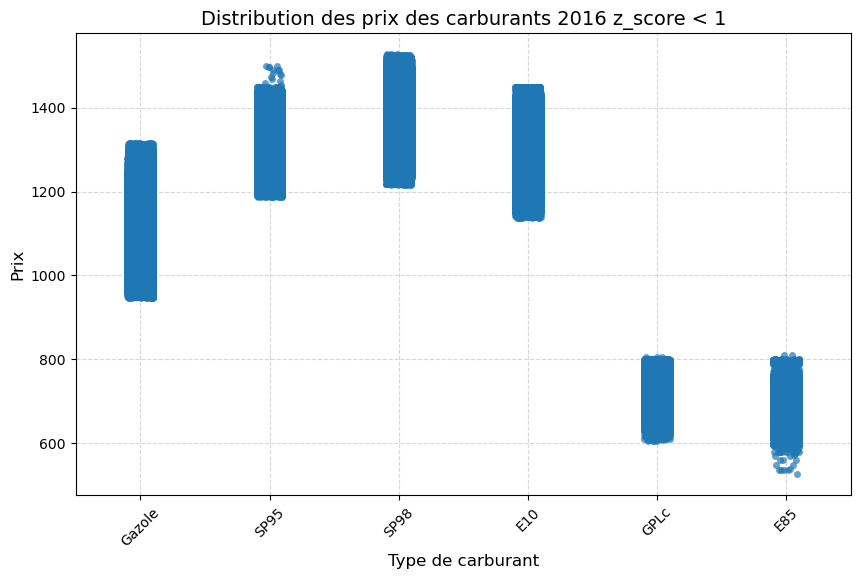

Save to CSV PrixCarburants_annuel_filtered_2016.csv
YEAR:  2017
        id   latitude  longitude    cp                  ville  \
0  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
1  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
2  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
3  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
4  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   

                 adresse     nom               maj  valeur  
0  596 AVENUE DE TREVOUX  Gazole  2017_01_02_09:37  1258.0  
1  596 AVENUE DE TREVOUX  Gazole  2017_01_03_09:54  1258.0  
2  596 AVENUE DE TREVOUX  Gazole  2017_01_06_12:33  1258.0  
3  596 AVENUE DE TREVOUX  Gazole  2017_01_09_08:59  1258.0  
4  596 AVENUE DE TREVOUX  Gazole  2017_01_10_10:38  1258.0  
        id   latitude  longitude    cp                  ville  \
0  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
1  1000001  4620114.0   519791.0  1000  SAINT-DEN

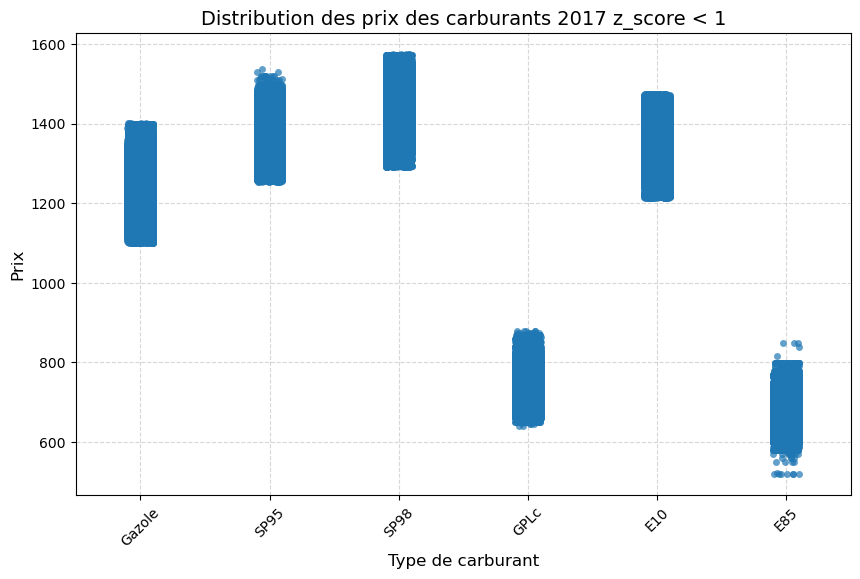

Save to CSV PrixCarburants_annuel_filtered_2017.csv
YEAR:  2018
        id   latitude  longitude    cp                  ville  \
0  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
1  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
2  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
3  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
4  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   

                 adresse     nom               maj  valeur  
0  596 AVENUE DE TREVOUX  Gazole  2018_01_06_12:20  1376.0  
1  596 AVENUE DE TREVOUX  Gazole  2018_01_11_09:09  1389.0  
2  596 AVENUE DE TREVOUX  Gazole  2018_01_12_13:16  1376.0  
3  596 AVENUE DE TREVOUX  Gazole  2018_01_18_11:05  1376.0  
4  596 AVENUE DE TREVOUX  Gazole  2018_01_18_11:13  1376.0  
        id   latitude  longitude    cp                  ville  \
0  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
1  1000001  4620114.0   519791.0  1000  SAINT-DEN

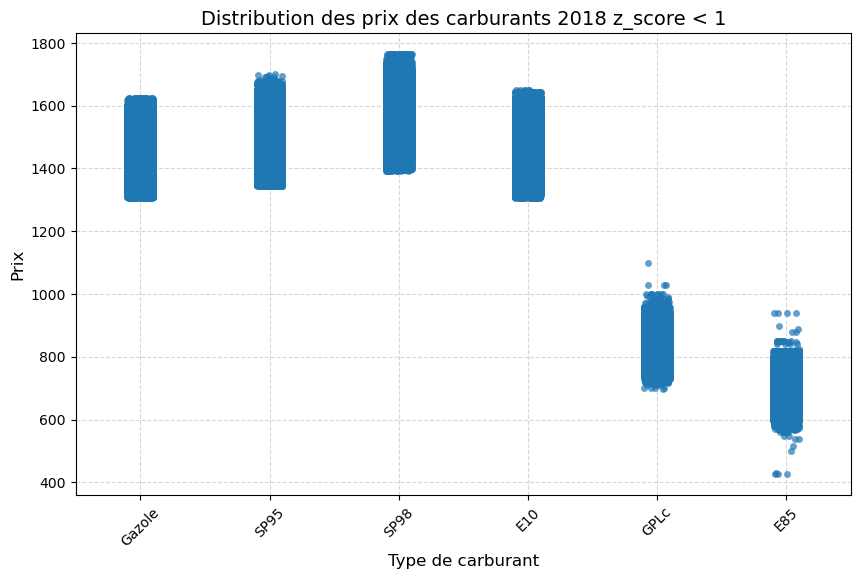

Save to CSV PrixCarburants_annuel_filtered_2018.csv
YEAR:  2019
        id   latitude  longitude    cp                  ville  \
0  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
1  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
2  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
3  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
4  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   

                 adresse     nom               maj  valeur  
0  596 AVENUE DE TREVOUX  Gazole  2019_01_04_10:53  1328.0  
1  596 AVENUE DE TREVOUX  Gazole  2019_01_07_10:25  1348.0  
2  596 AVENUE DE TREVOUX  Gazole  2019_01_10_08:54  1374.0  
3  596 AVENUE DE TREVOUX  Gazole  2019_01_11_10:01  1387.0  
4  596 AVENUE DE TREVOUX  Gazole  2019_01_14_11:04  1394.0  
        id   latitude  longitude    cp                  ville  \
0  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
1  1000001  4620114.0   519791.0  1000  SAINT-DEN

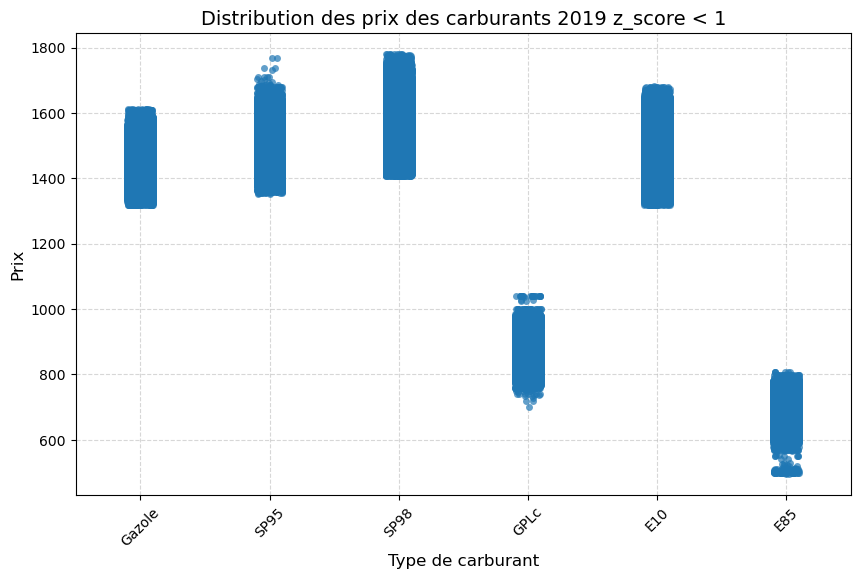

Save to CSV PrixCarburants_annuel_filtered_2019.csv
YEAR:  2020
        id   latitude  longitude    cp                  ville  \
0  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
1  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
2  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
3  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
4  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   

                 adresse     nom               maj  valeur  
0  596 AVENUE DE TREVOUX  Gazole  2020_01_03_10:36  1442.0  
1  596 AVENUE DE TREVOUX  Gazole  2020_01_06_10:36  1443.0  
2  596 AVENUE DE TREVOUX  Gazole  2020_01_07_10:48  1458.0  
3  596 AVENUE DE TREVOUX  Gazole  2020_01_28_15:18  1456.0  
4  596 AVENUE DE TREVOUX  Gazole  2020_01_30_10:13  1431.0  
        id   latitude  longitude    cp                  ville  \
0  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
1  1000001  4620114.0   519791.0  1000  SAINT-DEN

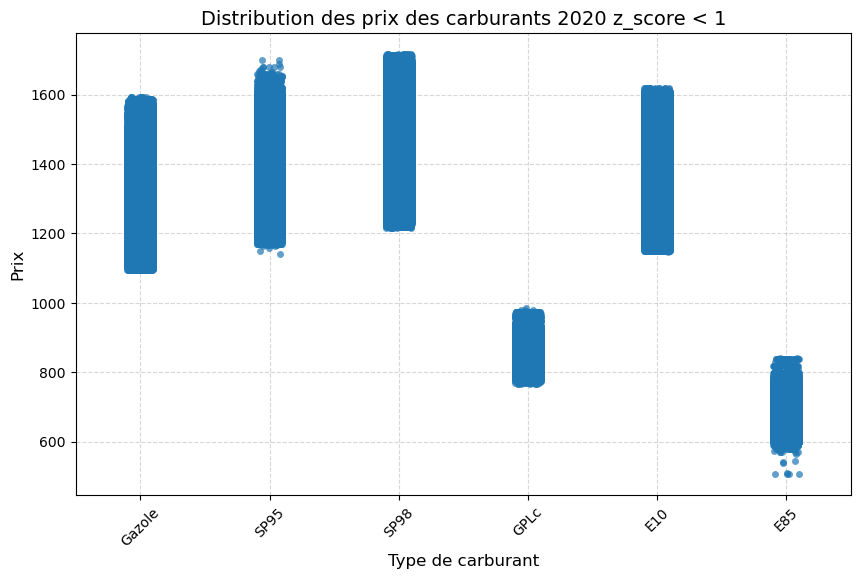

Save to CSV PrixCarburants_annuel_filtered_2020.csv
YEAR:  2021
        id   latitude  longitude    cp                  ville  \
0  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
1  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
2  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
3  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
4  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   

                 adresse     nom               maj  valeur  
0  596 AVENUE DE TREVOUX  Gazole  2021_01_02_15:13  1252.0  
1  596 AVENUE DE TREVOUX  Gazole  2021_01_04_09:28  1268.0  
2  596 AVENUE DE TREVOUX  Gazole  2021_01_06_09:29  1268.0  
3  596 AVENUE DE TREVOUX  Gazole  2021_01_06_15:45  1268.0  
4  596 AVENUE DE TREVOUX  Gazole  2021_01_07_09:44  1273.0  
        id   latitude  longitude    cp                  ville  \
0  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
1  1000001  4620114.0   519791.0  1000  SAINT-DEN

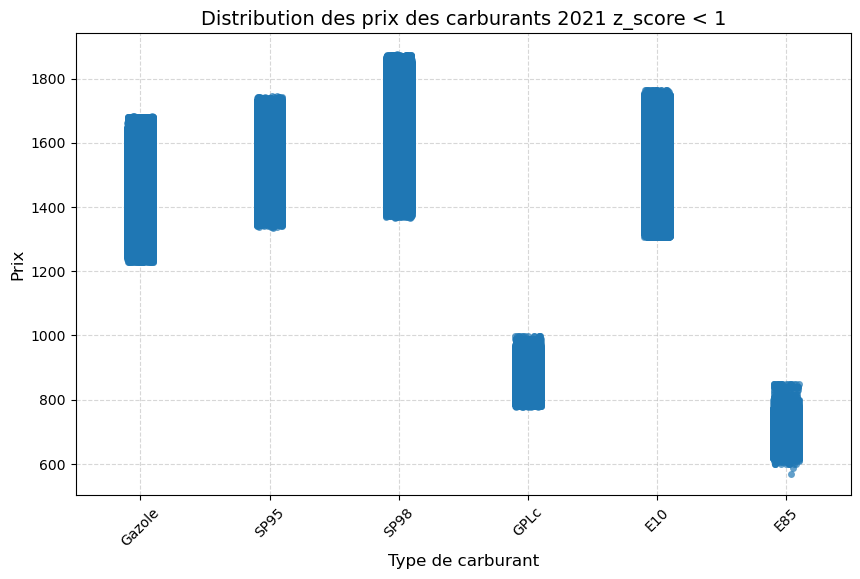

Save to CSV PrixCarburants_annuel_filtered_2021.csv
YEAR:  2022
        id   latitude  longitude    cp                  ville  \
0  1000001  4620100.0   519800.0  1000  SAINT-DENIS-LèS-BOURG   
1  1000001  4620100.0   519800.0  1000  SAINT-DENIS-LèS-BOURG   
2  1000001  4620100.0   519800.0  1000  SAINT-DENIS-LèS-BOURG   
3  1000001  4620100.0   519800.0  1000  SAINT-DENIS-LèS-BOURG   
4  1000001  4620100.0   519800.0  1000  SAINT-DENIS-LèS-BOURG   

                 adresse     nom               maj  valeur  
0  596 AVENUE DE TREVOUX  Gazole  2022_01_03_08:44  1572.0  
1  596 AVENUE DE TREVOUX  Gazole  2022_01_05_10:08  1560.0  
2  596 AVENUE DE TREVOUX  Gazole  2022_01_10_10:09  1603.0  
3  596 AVENUE DE TREVOUX  Gazole  2022_01_17_12:34  1616.0  
4  596 AVENUE DE TREVOUX  Gazole  2022_01_17_12:34  1616.0  
        id   latitude  longitude    cp                  ville  \
0  1000001  4620100.0   519800.0  1000  SAINT-DENIS-LèS-BOURG   
1  1000001  4620100.0   519800.0  1000  SAINT-DEN

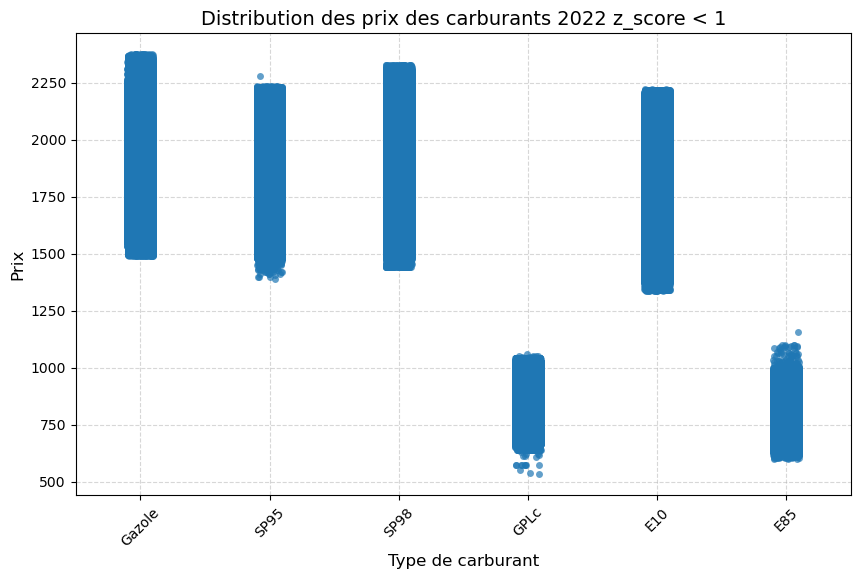

Save to CSV PrixCarburants_annuel_filtered_2022.csv
YEAR:  2023
        id   latitude  longitude    cp                  ville  \
0  1000001  4620100.0   519800.0  1000  SAINT-DENIS-LèS-BOURG   
1  1000001  4620100.0   519800.0  1000  SAINT-DENIS-LèS-BOURG   
2  1000001  4620100.0   519800.0  1000  SAINT-DENIS-LèS-BOURG   
3  1000001  4620100.0   519800.0  1000  SAINT-DENIS-LèS-BOURG   
4  1000001  4620100.0   519800.0  1000  SAINT-DENIS-LèS-BOURG   

                 adresse     nom               maj  valeur  
0  596 AVENUE DE TREVOUX  Gazole  2023_01_02_07:53  1867.0  
1  596 AVENUE DE TREVOUX  Gazole  2023_01_05_09:33  1877.0  
2  596 AVENUE DE TREVOUX  Gazole  2023_01_09_14:51  1875.0  
3  596 AVENUE DE TREVOUX  Gazole  2023_01_11_09:23  1859.0  
4  596 AVENUE DE TREVOUX  Gazole  2023_01_13_09:07  1862.0  
        id   latitude  longitude    cp                  ville  \
0  1000001  4620100.0   519800.0  1000  SAINT-DENIS-LèS-BOURG   
1  1000001  4620100.0   519800.0  1000  SAINT-DEN

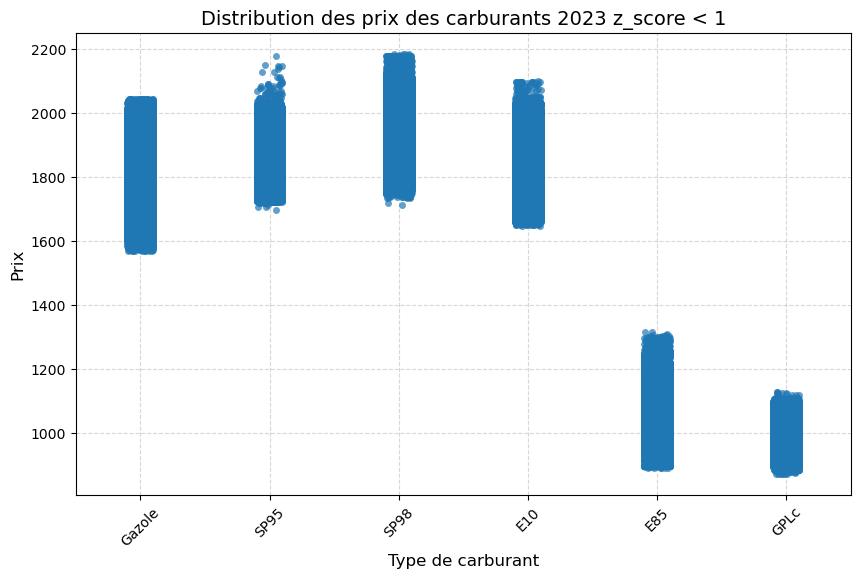

Save to CSV PrixCarburants_annuel_filtered_2023.csv
YEAR:  2024
        id   latitude  longitude    cp                  ville  \
0  1000001  4620100.0   519800.0  1000  SAINT-DENIS-LèS-BOURG   
1  1000001  4620100.0   519800.0  1000  SAINT-DENIS-LèS-BOURG   
2  1000001  4620100.0   519800.0  1000  SAINT-DENIS-LèS-BOURG   
3  1000001  4620100.0   519800.0  1000  SAINT-DENIS-LèS-BOURG   
4  1000001  4620100.0   519800.0  1000  SAINT-DENIS-LèS-BOURG   

                 adresse     nom               maj  valeur  
0  596 AVENUE DE TREVOUX  Gazole  2024_01_02_00:37  1706.0  
1  596 AVENUE DE TREVOUX  Gazole  2024_01_04_00:37  1699.0  
2  596 AVENUE DE TREVOUX  Gazole  2024_01_08_00:37  1701.0  
3  596 AVENUE DE TREVOUX  Gazole  2024_01_09_00:37  1713.0  
4  596 AVENUE DE TREVOUX  Gazole  2024_01_10_00:36  1699.0  
        id   latitude  longitude    cp                  ville  \
0  1000001  4620100.0   519800.0  1000  SAINT-DENIS-LèS-BOURG   
1  1000001  4620100.0   519800.0  1000  SAINT-DEN

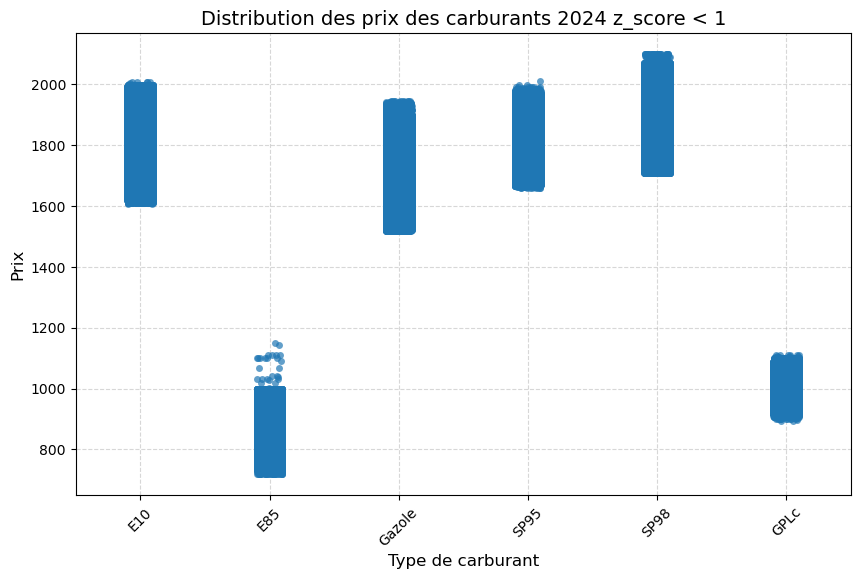

Save to CSV PrixCarburants_annuel_filtered_2024.csv
YEAR:  2025
        id   latitude  longitude    cp                  ville  \
0  1000001  4620100.0   519800.0  1000  SAINT-DENIS-LèS-BOURG   
1  1000001  4620100.0   519800.0  1000  SAINT-DENIS-LèS-BOURG   
2  1000001  4620100.0   519800.0  1000  SAINT-DENIS-LèS-BOURG   
3  1000001  4620100.0   519800.0  1000  SAINT-DENIS-LèS-BOURG   
4  1000001  4620100.0   519800.0  1000  SAINT-DENIS-LèS-BOURG   

                 adresse     nom               maj  valeur  
0  596 AVENUE DE TREVOUX  Gazole  2025_01_02_00:37  1707.0  
1  596 AVENUE DE TREVOUX  Gazole  2025_01_02_07:56  1707.0  
2  596 AVENUE DE TREVOUX  Gazole  2025_01_03_00:38  1725.0  
3  596 AVENUE DE TREVOUX  Gazole  2025_01_07_00:37  1705.0  
4  596 AVENUE DE TREVOUX  Gazole  2025_01_09_00:37  1688.0  
        id   latitude  longitude    cp                  ville  \
0  1000001  4620100.0   519800.0  1000  SAINT-DENIS-LèS-BOURG   
1  1000001  4620100.0   519800.0  1000  SAINT-DEN

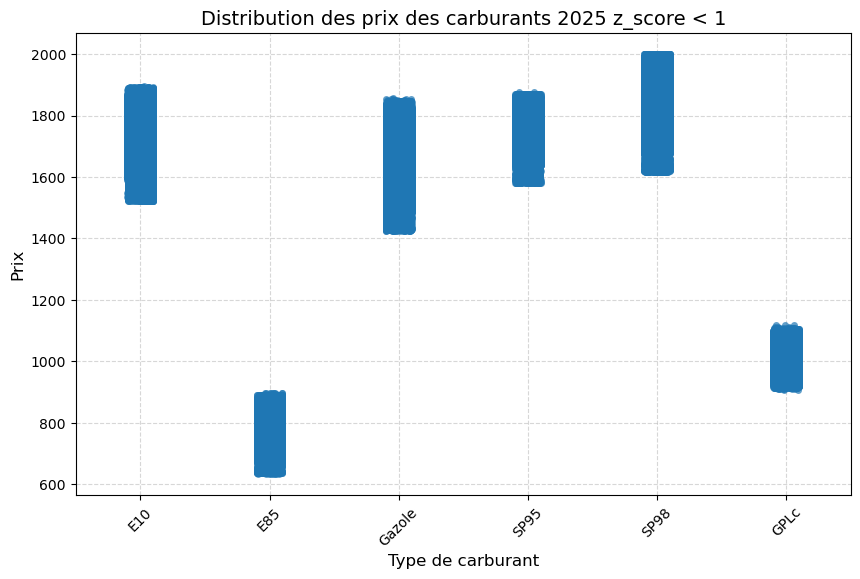

Save to CSV PrixCarburants_annuel_filtered_2025.csv


In [2]:
import pandas as pd
import numpy as np
import os
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore', category=RuntimeWarning)

# for i in range(1): # one year only
#     year = 2007
for i in range (19): # all years
    year = 2007+i
    print("YEAR: ", year)
    file_path = f"results/inputs_csv/PrixCarburants_annuel_{year}.csv"
    
    if not os.path.exists(file_path):
        print(f"Le fichier {file_path} n'existe pas.")
    else:
        df = pd.read_csv(file_path)
        print(df.head(5))

        df_prices = df.copy()
        df_prices['date'] = pd.to_datetime(df_prices['maj'], format='%Y_%m_%d_%H:%M', errors='coerce').dt.strftime('%Y_%m_%d')
        df_prices["date"] = pd.to_datetime(df_prices["date"], format="%Y_%m_%d")
        df_prices['heuremin'] = pd.to_datetime(df_prices['maj'], format='%Y_%m_%d_%H:%M', errors='coerce').dt.strftime('%H:%M')
        df_prices = df_prices.drop(columns=["maj"])
        
        print(df_prices.head(5))
        
        # check outliers min max values for each type carburant
        print(df_prices["nom"].unique())
        list_carburant = df_prices["nom"].dropna().unique()
        for carburant in list_carburant:
            df_carburant = df_prices[df_prices["nom"]== carburant]
            print(f"val MAX {carburant}", df_carburant.nlargest(3, 'valeur')['valeur'].tolist())
            print(f"val MIN {carburant}", df_carburant.nsmallest(3, 'valeur')['valeur'].tolist())

        # clean outlier data by Z-SCORE
        df_prices["z_score"] = df_prices.groupby(["date", "nom"])["valeur"].transform(lambda x: zscore(x, ddof=0))
        df_prices_filtered = df_prices[abs(df_prices["z_score"]) < 1]
        df_prices_filtered = df_prices_filtered.drop(columns=["z_score"])

        ### TRANSFORM VALUES TO KEEP ONLY LAST VALUES OF EACH DAY AFTER Z-SCORE FILTERING
        # df_prices_filtered['heuremin'] = pd.to_datetime(df_prices_filtered['heuremin'], format='%H:%M', errors='coerce').dt.time
        df_prices_filtered['heuremin'] = pd.to_datetime(df_prices_filtered['heuremin'], format='%H:%M', errors='coerce')
        df_prices_filtered = df_prices_filtered.sort_values(by=['id', 'date', 'nom', 'heuremin'])
        df_prices_filtered = df_prices_filtered.groupby(['id', 'date', 'nom'], as_index=False).last()

        print(df_prices_filtered.dtypes)
        
        plt.figure(figsize=(10, 6))
        sns.stripplot(data=df_prices_filtered, x="nom", y="valeur", jitter=True, alpha=0.7)   
        plt.title(f"Distribution des prix des carburants {year} z_score < 1", fontsize=14)
        plt.xlabel("Type de carburant", fontsize=12)
        plt.ylabel("Prix", fontsize=12)
        plt.xticks(rotation=45)
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()

        df_prices_filtered["date"] = df_prices_filtered["date"].dt.strftime('%Y_%m_%d')
        df_prices_filtered["heuremin"] = df_prices_filtered["heuremin"].dt.strftime('%H:%M')
        
        ########### SAVE DF TO CSV ###################
        os.makedirs("results/inputs_csv_zscore_last", exist_ok=True)
        df_prices_filtered.to_csv(f"results/inputs_csv_zscore_last/PrixCarburants_annuel_filtered_{year}.csv", index=False)
        print(f"Save to CSV PrixCarburants_annuel_filtered_{year}.csv")